In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Change the directory to the Tables folder
TABLE_DIR = '/content/drive/MyDrive/LLM causality/Tables/'
FIG_DIR = '/content/drive/MyDrive/LLM causality/Figures/'
FIG_DIR_0125 = '/content/drive/MyDrive/LLM causality/Figures/new/[1, 2, 3, 6]/'
FIG_DIR_0125_MC = '/content/drive/MyDrive/LLM causality/Figures/matrix_completion/'

import os
if not os.path.exists(FIG_DIR_0125_MC):
  os.makedirs(FIG_DIR_0125_MC)

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import seaborn as sns

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)

Saving utils_full.py to utils_full.py


44220

In [ ]:
from utils_full import *

This notebook comparesthe "global" approach for imputing missing observations with the "local approach". The difference is that the global approach uses data of all models, but the local approach only uses those with the selected four base models. We show that the local approach performs better. This is not surprising, because we already observe in the main paper that the principle component space of the full matrix is different from that of the selected submatrix.

In [ ]:
# Base models that we will look at
frequent_base_models_new = ['llama-3.1-8b', 'qwen2.5-14b', 'qwen2.5-7b', 'qwen2.5-0.5b', 'mistral-7b', 'gemma-2-9b']
# Benchmarks included in the leaderboard
cols_to_transform_new = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']
# Load the leaderboard
df_filtered_new = pd.read_csv(TABLE_DIR + 'open_llm_leaderboard_with_tokens.csv')

model_names = ['qwen2.5-14b']
X = df_filtered_new[cols_to_transform_new].values
X_subset = select_data(df_filtered_new, cols_to_transform_new, model_names)

We use the k-nearest neighbor algorithm to perform matrix completion.

In [ ]:
np.random.seed(2025)

n_rows, n_cols = X.shape

M = 1000 # Repeat the experiment M times

def hide_column_entries(X, column_index, percentage):
  """Hides a percentage of entries in a specified column of a NumPy array.

  Args:
    X: The NumPy array to modify.
    column_index: The index of the column to hide entries in (0-based).
    percentage: The percentage of entries to hide (between 0 and 1).

  Returns:
    A copy of the array with entries hidden in the specified column.
  """

  X_masked = X.copy()
  num_rows = X.shape[0]
  num_entries_to_hide = int(num_rows * percentage)
  indices_to_hide = np.random.choice(num_rows, size=num_entries_to_hide, replace=False)
  for c in column_index:
    X_masked[indices_to_hide, c] = np.nan  # Use np.nan to represent hidden entries
  return X_masked

def rmse(random_scheme = 'random', column_index = None):

  global_rmse_list = []
  local_rmse_list = []

  for m in range(M):

    if random_scheme == 'random':
      random_matrix = np.random.rand(n_rows, n_cols)
      # Create a boolean mask where 'True' means the element is *not* masked (observed)
      mask = random_matrix > 0.8
      # Create the masked matrix (using np.nan for missing entries)
      X_masked = X.copy()
      X_masked[~mask] = np.nan
    elif random_scheme == 'col':
      X_masked = hide_column_entries(X, column_index=column_index, percentage=0.8)
      mask = ~np.isnan(X_masked)

    # --- Step 2: Define a subset of rows ---
    subset_indices = choose_subset_indices(df_filtered_new, model_names)

    # --- KNN Matrix Completion Function ---
    def knn_matrix_completion(X_incomplete, n_neighbors=5):
        """
        Complete the matrix using k-nearest neighbors imputation.

        Parameters:
            X_incomplete: 2D numpy array with np.nan at missing entries.
            n_neighbors: Number of neighbors to use for imputation.

        Returns:
            X_completed: Completed matrix.
        """
        imputer = KNNImputer(n_neighbors=n_neighbors)
        X_completed = imputer.fit_transform(X_incomplete)
        return X_completed

    # --- Approach 1: Global Completion using KNN ---
    X_completed_global = knn_matrix_completion(X_masked)

    # --- Approach 2: Local Completion on the subset using KNN ---
    # Extract the submatrix corresponding to the subset indices.
    X_subset_masked = X_masked[subset_indices, :]
    X_completed_local = knn_matrix_completion(X_subset_masked)
    # print(X_completed_local.shape)

    # --- Step 3: Evaluate Performance ---
    # Compute the MSE on the missing entries in the submatrix.

    # For the global completion, extract the corresponding rows.
    global_missing = ~mask[subset_indices, :]
    global_errors = (X[subset_indices, :][global_missing] - X_completed_global[subset_indices, :][global_missing]) ** 2
    global_mse = np.nanmean(global_errors)

    # For the local completion, compare the imputed submatrix with the true values.
    local_missing = ~mask[subset_indices, :]
    local_errors = (X[subset_indices, :][local_missing] - X_completed_local[local_missing]) ** 2
    local_mse = np.nanmean(local_errors)

    global_rmse_list.append(global_mse ** 0.5)
    local_rmse_list.append(local_mse ** 0.5)

  return global_rmse_list, local_rmse_list

Compare the RMSE of the global and local approach.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_rmse(global_rmse_list, local_rmse_list, fig_text, method = 'MC-kNN'):

  sns.set_style("whitegrid")
  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.size'] = 14  # Increased base font size

  colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B3']

  # Create a figure with better dimensions
  plt.figure(figsize=(10, 5))

  # Add grid for better readability
  plt.grid(True, linestyle='--', alpha=0.4, axis='both')

  # Calculate bin edges to ensure equal width for both histograms
  min_rmse = min(min(global_rmse_list), min(local_rmse_list))
  max_rmse = max(max(global_rmse_list), max(local_rmse_list))
  bin_edges = np.linspace(min_rmse, max_rmse, 31)  # 31 edges for 30 bins

  # Plot histograms with improved styling, equal bin widths, and probability density
  plt.hist(global_rmse_list, bins=bin_edges, color=colors[0], edgecolor='black',
            alpha=0.6, label='Global ' + method, linewidth=0.8, density=True)
  plt.hist(local_rmse_list, bins=bin_edges, color=colors[1], edgecolor='black',
            alpha=0.6, label='Local ' + method, linewidth=0.8, density=True)

  # Add vertical lines for means with improved styling
  global_mean = np.mean(global_rmse_list)
  local_mean = np.mean(local_rmse_list)

  plt.axvline(global_mean, color=colors[0], linestyle='--', linewidth=2.5,
              label=f'Global Mean: {global_mean:.4f}')
  plt.axvline(local_mean, color=colors[1], linestyle='--', linewidth=2.5,
              label=f'Local Mean: {local_mean:.4f}')

  # Add markers at mean values
  plt.plot([global_mean], [0], marker='o', markersize=10, color=colors[0],
          markeredgecolor='black', markeredgewidth=1.5)
  plt.plot([local_mean], [0], marker='o', markersize=10, color=colors[1],
          markeredgecolor='black', markeredgewidth=1.5)

  # Improve axis labels with larger font
  plt.xlabel('RMSE', fontsize=18, fontweight='bold')
  plt.ylabel('Density', fontsize=18, fontweight='bold')

  # Set axis ticks with larger font
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)

  # Ensure y-axis starts at 0
  plt.ylim(bottom=0)

  # Find common x-axis range to display both distributions properly
  min_x = min(min(global_rmse_list), min(local_rmse_list))
  max_x = max(max(global_rmse_list), max(local_rmse_list))
  plt.xlim(min_x * 0.9, max_x * 1.1)  # Add 10% padding

  # Improve legend with better styling
  plt.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=14, title_fontsize=16,
            edgecolor='black', fancybox=True)

  # Adjust layout
  plt.tight_layout()

  # Uncomment to save the figure
  plt.savefig(FIG_DIR_0125_MC + fig_text + '_rmse_global_local.pdf', dpi=300, bbox_inches='tight')

In [ ]:
pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=2ae787427d7abe35703fbd0be50e4bab16d9ece76424c834cb02d16681d8498b
  Stored in directory: /root/.cache/pip/wheels/1a/f3/a1/f7f10b5ae2c2459398762a3fcf4ac18c325311c7e3163d5a15
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=d1300593ac2b59cd8b9cb6ca0507dbffdaf27f96f2cc8d2a456f16b1d0f70a1a
  Stored in directory: /root/.cache/pip/wheels/ea/e8/e0/79872972161e54486517ae507f94b2c7cea27fb7ef793bd415
Successfully built fancyimpute knnimpute


In [ ]:
from fancyimpute import SoftImpute

In [ ]:
# --- SoftImpute Matrix Completion Function ---
def soft_impute_matrix_completion(X_incomplete, shrink_lambda=None, max_rank=3, verbose=False):
    """
    Complete the matrix using SoftImpute (based on nuclear norm regularization).

    Parameters:
        X_incomplete: 2D numpy array with np.nan at missing entries.
        shrink_lambda: Shrinkage value for soft-thresholding.
                       If None, fancyimpute might use a default or estimate it.
        max_rank: Maximum rank of the imputed matrix.
                  If None, fancyimpute might use a default.
        verbose: Whether to print convergence messages.

    Returns:
        X_completed: Completed matrix.
    """
    # Initialize SoftImpute
    params = {'verbose': verbose}
    if shrink_lambda is not None:
        params['shrink_lambda'] = shrink_lambda
    if max_rank is not None:
        params['max_rank'] = max_rank

    imputer = SoftImpute(**params)
    X_completed = imputer.fit_transform(X_incomplete)
    return X_completed

In [ ]:
import os
import numpy as np
import pandas as pd # Assuming df_filtered_new might be a pandas DataFrame

# --- rpy2 and R Setup for Google Colab ---
IN_COLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'get_ipython') else False

def setup_r_and_structuremc_colab():
    """
    Installs R, rpy2, and the StructureMC R package in a Google Colab environment.
    """
    if IN_COLAB:
        print("Running in Google Colab. Setting up R and StructureMC...")
        # Install R and essentials
        os.system('sudo apt-get update -qq && sudo apt-get install --no-install-recommends r-base r-base-dev -qq')
        # Install rpy2
        os.system('pip install rpy2==3.5.13') # Using a specific version for stability

        # Activate R magic if not already (for potential direct R cell use)
        try:
            get_ipython().run_line_magic('load_ext', 'rpy2.ipython')
        except Exception as e:
            print(f"Could not load rpy2.ipython extension: {e}")

        # Install StructureMC R package
        import rpy2.robjects as robjects
        from rpy2.robjects.packages import importr
        utils = importr('utils')
        try:
            # Check if StructureMC is already installed
            structure_mc_check = importr('StructureMC', lib_loc="/usr/local/lib/R/site-library")
            print("StructureMC R package is already installed.")
        except robjects.packages.PackageNotInstalledError:
            print("Installing StructureMC R package...")
            # Set a CRAN mirror
            robjects.r('chooseCRANmirror(ind=1)') # Choose the first mirror (e.g., 0-Cloud)
            # Install StructureMC
            utils.install_packages('StructureMC', lib="/usr/local/lib/R/site-library", repos=robjects.r('getOption("repos")'))
            print("StructureMC R package installed.")
        except Exception as e:
            print(f"An error occurred with StructureMC R package: {e}")
        print("R and StructureMC setup complete.")
    else:
        print("Not running in Google Colab. Assuming R, rpy2, and StructureMC are pre-installed if needed.")

# Call setup if in Colab (run this cell early in your notebook)
if IN_COLAB:
    setup_r_and_structuremc_colab() # You might run this in a separate cell

# Now, import rpy2 components safely after potential installation
try:
    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr
    from rpy2.robjects import numpy2ri
    # from rpy2.robjects import pandas2ri # Uncomment if using pandas DataFrames directly with R
    R_IS_SETUP = True
except ImportError:
    R_IS_SETUP = False
    print("Warning: rpy2 is not installed. SMC functionality will not be available.")
    print("If in Colab, ensure setup_r_and_structuremc_colab() has run successfully.")
except Exception as e:
    R_IS_SETUP = False
    print(f"Warning: Error importing rpy2: {e}. SMC functionality will not be available.")

Running in Google Colab. Setting up R and StructureMC...
Installing StructureMC R package...







	‘/tmp/RtmpuKb78d/downloaded_packages’



StructureMC R package installed.
R and StructureMC setup complete.


In [ ]:
import numpy as np

M = 500

main_list = list(range(6))

global_rmse_list, local_rmse_list = [], []

def rmse(random_scheme='random', column_index=None,
         smc_m1=None, smc_m2=None, # For 'smc_block'
         # New parameters for the custom structured missing scheme
         fixed_cols_observed=None,
         percentage_rows_missing_others=None,
         soft_impute_max_rank=3,    # Parameter for SoftImpute
         verbose_soft_impute=False  # Verbosity for SoftImpute
         ):
    """
    Calculates RMSE for matrix completion using SoftImpute or SMC.

    Parameters:
        random_scheme (str): 'random', 'col', 'smc_block', or 'fixed_cols_structured_missing'.
        column_index (list or int): Column index/indices for 'col' scheme.
        smc_m1 (int): Number of rows in the A11 block for 'smc_block' scheme.
        smc_m2 (int): Number of columns in the A11 block for 'smc_block' scheme.
        fixed_cols_observed (list or int): Column index/indices that are fully observed
                                           for 'fixed_cols_structured_missing' scheme.
        percentage_rows_missing_others (float): Percentage of rows to make missing in
                                                other columns for
                                                'fixed_cols_structured_missing' scheme (e.g., 0.8 for 80%).
        soft_impute_max_rank (int): Max rank parameter for SoftImpute.
        verbose_soft_impute (bool): Verbosity for SoftImpute calls.

    Returns:
        tuple: (global_rmse_list, local_rmse_list)
    """
    global X, M, df_filtered_new, model_names # Make sure these are accessible

    global_rmse_list = []
    local_rmse_list = []

    if 'X' not in globals() or X is None:
        print("Error: Data matrix 'X' is not defined globally or is None.")
        return [], []
    if 'M' not in globals() or M <= 0:
        print("Error: Number of iterations 'M' must be positive.")
        return [], []

    n_rows, n_cols = X.shape

    for m_iter in range(M): # Renamed loop variable
        if m_iter % (M // 10) == 0 and M >= 10 and M > 0: # Print progress
            print(f"Processing iteration {m_iter + 1}/{M}...")

        X_masked = X.copy()
        # True means observed, False means masked (hidden/NaN)
        mask_observed = np.ones_like(X, dtype=bool)
        true_A22_block_for_smc = None # Only used for smc_block direct eval

        if random_scheme == 'random':
            random_matrix = np.random.rand(n_rows, n_cols)
            mask_observed = random_matrix > percentage_rows_missing_others  # True for observed (80%), False for masked (20%)
            X_masked[~mask_observed] = np.nan
        elif random_scheme == 'col':
            if column_index is None:
                print("Error: 'column_index' must be provided for 'col' scheme.")
                global_rmse_list.append(np.nan); local_rmse_list.append(np.nan); continue
            X_masked = hide_column_entries(X, column_index, percentage=0.8) # Hides 80%
            mask_observed = ~np.isnan(X_masked)
        elif random_scheme == 'smc_block':
            if smc_m1 is None or smc_m2 is None:
                print("Error: 'smc_m1' and 'smc_m2' must be provided for 'smc_block' scheme.")
                global_rmse_list.append(np.nan); local_rmse_list.append(np.nan); continue
            if not (0 < smc_m1 < n_rows and 0 < smc_m2 < n_cols):
                print(f"Error: smc_m1 ({smc_m1}) and smc_m2 ({smc_m2}) must be within matrix dimensions ({n_rows}x{n_cols}).")
                global_rmse_list.append(np.nan); local_rmse_list.append(np.nan); continue

            X_masked[smc_m1:, smc_m2:] = np.nan # Mask the A22 block (bottom-right)
            mask_observed = ~np.isnan(X_masked) # A11, A12, A21 are observed
            true_A22_block_for_smc = X[smc_m1:, smc_m2:]
        elif random_scheme == 'fixed_cols_structured_missing':
            if fixed_cols_observed is None or percentage_rows_missing_others is None:
                print("Error: 'fixed_cols_observed' and 'percentage_rows_missing_others' must be provided for 'fixed_cols_structured_missing' scheme.")
                global_rmse_list.append(np.nan); local_rmse_list.append(np.nan); continue
            if not (0.0 < percentage_rows_missing_others < 1.0):
                print("Error: 'percentage_rows_missing_others' must be between 0 and 1 (exclusive).")
                global_rmse_list.append(np.nan); local_rmse_list.append(np.nan); continue

            current_fixed_cols = np.array(fixed_cols_observed, dtype=int).ravel() # Ensure it's an array of int

            # Initialize mask_observed: all true, then set specific parts to false
            mask_observed = np.ones_like(X, dtype=bool)

            all_col_indices = np.arange(n_cols)
            other_cols_to_mask = np.setdiff1d(all_col_indices, current_fixed_cols)

            num_rows_to_hide = int(n_rows * percentage_rows_missing_others)

            if num_rows_to_hide > 0:
                for col_idx in other_cols_to_mask:
                    if 0 <= col_idx < n_cols: # Boundary check for safety
                        row_indices_to_hide = np.random.choice(n_rows, size=num_rows_to_hide, replace=False)
                        X_masked[row_indices_to_hide, col_idx] = np.nan
                        mask_observed[row_indices_to_hide, col_idx] = False
                    else:
                        print(f"Warning: Column index {col_idx} from 'other_cols_to_mask' is out of bounds.")
            # Columns in fixed_cols_observed remain fully observed (mask_observed is True there by default)

        else:
            print(f"Error: Unknown random_scheme '{random_scheme}'")
            global_rmse_list.append(np.nan); local_rmse_list.append(np.nan); continue

        # --- Global Completion Step ---
        X_completed_global = X_masked.copy() # Initialize with masked values

        if np.all(np.isnan(X_masked)):
            print(f"Warning: X_masked is all NaN before global completion for iter {m_iter+1}.")
        elif random_scheme == 'smc_block':
            recovered_A22_block = py_smc_reconstruct_missing_block(X_masked.copy(), smc_m1, smc_m2)
            if recovered_A22_block is not None and \
               true_A22_block_for_smc is not None and \
               recovered_A22_block.shape == true_A22_block_for_smc.shape:
                X_completed_global[smc_m1:, smc_m2:] = recovered_A22_block
            else:
                print(f"Warning: SMC recovery failed or shape mismatch for iter {m_iter+1}. A22 not imputed in X_completed_global.")
                X_completed_global[smc_m1:, smc_m2:] = np.nan
        else: # 'random', 'col', or 'fixed_cols_structured_missing' schemes use SoftImpute for global
            X_completed_global = soft_impute_matrix_completion(
                X_masked.copy(),
                max_rank=soft_impute_max_rank,
                verbose=verbose_soft_impute
            )

        # --- Step 2: Define a subset of rows ---
        subset_indices = choose_subset_indices(df_filtered_new, model_names)

        # --- Evaluate Performance based on user's original RMSE structure ---
        if not isinstance(subset_indices, (np.ndarray, list)) or len(subset_indices) == 0:
            print(f"Warning: subset_indices is empty or invalid for iter {m_iter+1}. Skipping local completion.")
            local_rmse_list.append(np.nan)
            if np.all(np.isnan(X_masked)):
                global_rmse_list.append(np.nan)
            else:
                global_rmse_list.append(np.nan) # As per user's logic for empty subset
            continue

        X_subset_masked = X_masked[subset_indices, :]
        if np.all(np.isnan(X_subset_masked)):
            print(f"Warning: X_subset_masked is all NaN for iter {m_iter+1}. Cannot perform local completion.")
            local_rmse_list.append(np.nan)
            if np.all(np.isnan(X_completed_global)):
                 global_rmse_list.append(np.nan)
            else:
                global_missing_in_subset = ~mask_observed[subset_indices, :]
                if np.sum(global_missing_in_subset) > 0:
                    global_errors = (X[subset_indices, :][global_missing_in_subset] - X_completed_global[subset_indices, :][global_missing_in_subset]) ** 2
                    global_mse = np.nanmean(global_errors)
                    global_rmse_list.append(global_mse ** 0.5 if not np.isnan(global_mse) else np.nan)
                else:
                    global_rmse_list.append(0.0)
            continue

        X_completed_local = soft_impute_matrix_completion(
            X_subset_masked.copy(),
            max_rank=soft_impute_max_rank,
            verbose=verbose_soft_impute
        )

        global_missing_in_subset = ~mask_observed[subset_indices, :]
        if np.sum(global_missing_in_subset) > 0:
            if np.all(np.isnan(X_completed_global)): # Check if global completion failed entirely
                 global_rmse_list.append(np.nan)
            else:
                global_errors = (X[subset_indices, :][global_missing_in_subset] - X_completed_global[subset_indices, :][global_missing_in_subset]) ** 2
                global_mse = np.nanmean(global_errors)
                global_rmse_list.append(global_mse ** 0.5 if not np.isnan(global_mse) else np.nan)
        else:
            global_rmse_list.append(0.0)

        local_original_subset_missing_mask = ~mask_observed[subset_indices, :]
        if np.sum(local_original_subset_missing_mask) > 0:
            if np.all(np.isnan(X_completed_local)): # Check if local completion failed entirely
                local_rmse_list.append(np.nan)
            else:
                local_errors = (X[subset_indices, :][local_original_subset_missing_mask] - X_completed_local[local_original_subset_missing_mask]) ** 2
                local_mse = np.nanmean(local_errors)
                local_rmse_list.append(local_mse ** 0.5 if not np.isnan(local_mse) else np.nan)
        else:
            local_rmse_list.append(0.0)

    print(f"Finished {M} iterations.")
    return global_rmse_list, local_rmse_list

In [ ]:
import warnings
import os

M = 100

# Set seed for reproducibility
np.random.seed(2025)

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Configuration ---
# Define the percentages of rows to hide in 'other' columns
percentages_to_hide = [0.1 * i for i in range(1, 10)]
soft_impute_rank_to_test = 3 # Example max_rank for SoftImpute

# Directory to save results (figures and RMSE lists)
results_dir = "results_fixed_cols_evaluation"
os.makedirs(FIG_DIR_0125_MC + results_dir, exist_ok=True) # Create directory if it doesn't exist

# --- Data Storage ---
# Dictionaries to store combined RMSEs for each percentage
# Key: percentage_to_hide, Value: list of all RMSEs from all sublists for that percentage
all_global_rmses_by_percentage = {p: [] for p in percentages_to_hide}
all_local_rmses_by_percentage = {p: [] for p in percentages_to_hide}


if 'X' not in globals() or X is None: # Check if X is already defined by user
    print("INFO: Global data matrix 'X' is not defined. Using a random 100x6 matrix for demonstration.")
    X = np.random.rand(100, 6) # Example: 100 rows, 6 columns

if 'main_list' not in globals() or main_list is None:
    print(f"INFO: 'main_list' is not defined. Using all columns from X: {list(range(X.shape[1]))}")
    main_list = list(range(X.shape[1]))

if 'M' not in globals() or M is None:
    print("INFO: Global number of iterations 'M' is not defined. Using M=10 for demonstration.")
    M = 10 # Number of iterations for each rmse call

# --- Iteration and Evaluation ---
# Outer loop: Iterate over each percentage_to_hide_in_others
for p_hide in percentages_to_hide:
    print(f"\nProcessing for percentage_to_hide_in_others: {p_hide*100:.0f}%")

    # Lists to store RMSEs for the current percentage, across all sublist combinations
    current_percentage_global_rmses = []
    current_percentage_local_rmses = []

    # Inner loop: Iterate over combinations of 3 fixed columns from main_list
    if not main_list or len(main_list) < 3:
        print(f"Warning: main_list ({main_list}) is too short to form combinations of 3. Skipping for p_hide={p_hide}.")
        continue

    for sublist in itertools.combinations(main_list, 3):
        fixed_cols = list(sublist) # Convert tuple to list

        # Validate fixed_cols against the dimensions of X
        if X is not None and any(fc < 0 or fc >= X.shape[1] for fc in fixed_cols):
            print(f"  Error: One or more columns in fixed_cols_observed ({fixed_cols}) are out of bounds for X with {X.shape[1]} columns. Skipping this sublist.")
            continue
        elif X is None:
            print(f"  Error: Data matrix X is None. Cannot proceed with sublist {fixed_cols}. Skipping this sublist.")
            continue


        print(f"\n  Running 'fixed_cols_structured_missing' scheme for p_hide={p_hide*100:.0f}%...")
        print(f"  Fixed observed columns: {fixed_cols}")

        # Call the rmse function
        global_rmse_custom, local_rmse_custom = rmse(
            random_scheme='fixed_cols_structured_missing',
            fixed_cols_observed=fixed_cols,
            percentage_rows_missing_others=p_hide,
            soft_impute_max_rank=soft_impute_rank_to_test
            )

        # Append results from this sublist's M iterations to the current percentage's lists
        current_percentage_global_rmses.extend(global_rmse_custom)
        current_percentage_local_rmses.extend(local_rmse_custom)

        print(f"  Results for fixed_cols {fixed_cols}, p_hide {p_hide*100:.0f}%:")
        if global_rmse_custom: # Check if list is not empty
             print(f"    Global RMSEs (mean): {np.nanmean(global_rmse_custom):.4f} (first 3: {['{:.4f}'.format(r) if not np.isnan(r) else 'nan' for r in global_rmse_custom[:3]]})")
        if local_rmse_custom:
             print(f"    Local RMSEs (mean): {np.nanmean(local_rmse_custom):.4f} (first 3: {['{:.4f}'.format(r) if not np.isnan(r) else 'nan' for r in local_rmse_custom[:3]]})")


        # Generate and save individual plot for this specific sublist and percentage
        fig_identifier = f'fixed_cols_{"_".join(map(str, fixed_cols))}_perc_{int(p_hide*100)}_rank{soft_impute_rank_to_test}'
        plot_file_name = os.path.join(results_dir, fig_identifier)
        plot_rmse(global_rmse_custom, local_rmse_custom, fig_text=plot_file_name, method = 'MC-NNR')

    # After iterating through all sublists for the current p_hide:
    # Store all collected RMSEs for this percentage
    all_global_rmses_by_percentage[p_hide] = current_percentage_global_rmses
    all_local_rmses_by_percentage[p_hide] = current_percentage_local_rmses

    # Save the combined RMSE lists for the current percentage to files
    global_rmse_filename = os.path.join(FIG_DIR_0125_MC+results_dir, f"global_rmses_perc_{int(p_hide*100)}_rank{soft_impute_rank_to_test}.txt")
    local_rmse_filename = os.path.join(FIG_DIR_0125_MC+results_dir, f"local_rmses_perc_{int(p_hide*100)}_rank{soft_impute_rank_to_test}.txt")

    try:
        np.savetxt(global_rmse_filename, current_percentage_global_rmses, fmt='%.8f', header=f'Global RMSEs for {p_hide*100}% missing in others, rank {soft_impute_rank_to_test}')
        print(f"\n  Saved global RMSEs for p_hide={p_hide*100:.0f}% to {global_rmse_filename}")
    except Exception as e:
        print(f"  Error saving global RMSEs for p_hide={p_hide*100:.0f}%: {e}")

    try:
        np.savetxt(local_rmse_filename, current_percentage_local_rmses, fmt='%.8f', header=f'Local RMSEs for {p_hide*100}% missing in others, rank {soft_impute_rank_to_test}')
        print(f"  Saved local RMSEs for p_hide={p_hide*100:.0f}% to {local_rmse_filename}")
    except Exception as e:
        print(f"  Error saving local RMSEs for p_hide={p_hide*100:.0f}%: {e}")


print("\n--- All percentages processed. ---")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
labels = [f"{p*100:.0f}%" for p in percentages_to_hide]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars/boxes

fig, ax = plt.subplots(figsize=(10, 6)) # Increased figure size for better readability

# Prepare data for plotting, ensuring we only plot if data exists
global_plot_data = [all_global_rmses_by_percentage[p] for p in percentages_to_hide if all_global_rmses_by_percentage[p]]
local_plot_data = [all_local_rmses_by_percentage[p] for p in percentages_to_hide if all_local_rmses_by_percentage[p]]

# Filter labels to match available data
valid_labels_global = [f"{p*100:.0f}%" for p in percentages_to_hide if all_global_rmses_by_percentage[p]]
valid_labels_local = [f"{p*100:.0f}%" for p in percentages_to_hide if all_local_rmses_by_percentage[p]]

# We need to ensure that global_plot_data and local_plot_data have the same number of groups
# for side-by-side plotting. We'll use the intersection of percentages for which both have data.
plot_percentages = [p for p in percentages_to_hide if all_global_rmses_by_percentage[p] and all_local_rmses_by_percentage[p]]
if not plot_percentages:
    print("\nNo data available for combined summary boxplot (either global or local RMSEs are missing for all percentages).")
else:
    labels_for_plot = [f"{p*100:.0f}%" for p in plot_percentages]
    x_ticks_positions = np.arange(len(labels_for_plot))

    data_group1 = [all_global_rmses_by_percentage[p] for p in plot_percentages]
    data_group2 = [all_local_rmses_by_percentage[p] for p in plot_percentages]

    # Plotting global RMSEs
    bp1 = ax.boxplot(data_group1, positions=x_ticks_positions - width/2, widths=width*0.8, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', edgecolor='blue'),
                     medianprops=dict(color='navy'),
                     whiskerprops=dict(color='blue'),
                     capprops=dict(color='blue'),
                     flierprops=dict(markerfacecolor='blue', markeredgecolor='blue', marker='o', markersize=5))

    # Plotting local RMSEs
    bp2 = ax.boxplot(data_group2, positions=x_ticks_positions + width/2, widths=width*0.8, patch_artist=True,
                     boxprops=dict(facecolor='lightgreen', edgecolor='green'),
                     medianprops=dict(color='darkgreen'),
                     whiskerprops=dict(color='green'),
                     capprops=dict(color='green'),
                     flierprops=dict(markerfacecolor='green', markeredgecolor='green', marker='o', markersize=5))

    ax.set_ylabel('RMSE', fontweight = 'bold', fontsize = 20)
    ax.set_xlabel('Percentage of Rows Hidden', fontweight = 'bold', fontsize = 20)
    ax.set_title(f'Comparison of Global and Local MC-NNR', fontweight = 'bold', fontsize = 20)
    ax.set_xticks(x_ticks_positions)
    ax.set_xticklabels(labels_for_plot)
    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Global RMSE', 'Local RMSE'], loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to make sure everything fits

    summary_combined_fig_path = os.path.join(FIG_DIR_0125_MC + results_dir, f"summary_boxplot_combined_rmse_rank{soft_impute_rank_to_test}.pdf")
    try:
        plt.savefig(summary_combined_fig_path)
        print(f"\nSaved combined summary RMSE boxplot to {summary_combined_fig_path}")
    except Exception as e:
        print(f"Error saving combined summary RMSE boxplot: {e}")
    plt.close()

print("\nScript finished.")


Saved combined summary RMSE boxplot to /content/drive/MyDrive/LLM causality/Figures/matrix_completion/results_fixed_cols_evaluation/summary_boxplot_combined_rmse_rank3.pdf

Script finished.



Processing for 'random' scheme with overall percentage_to_hide: 10%
Processing iteration 1/500...
Processing iteration 51/500...
Processing iteration 101/500...
Processing iteration 151/500...
Processing iteration 201/500...
Processing iteration 251/500...
Processing iteration 301/500...
Processing iteration 351/500...
Processing iteration 401/500...
Processing iteration 451/500...
Finished 500 iterations.
  Results for 'random' scheme, p_hide 10%:
    Global RMSEs (mean): 11.3655 (first 3: ['12.0298', '11.9678', '11.5675'])
    Local RMSEs (mean): 7.9451 (first 3: ['10.3276', '10.6090', '8.2998'])
  Error saving global RMSEs for p_hide=10%: [Errno 2] No such file or directory: 'results_random_missing_evaluation/global_rmses_random_perc_10_rank3.txt'
  Error saving local RMSEs for p_hide=10%: [Errno 2] No such file or directory: 'results_random_missing_evaluation/local_rmses_random_perc_10_rank3.txt'

Processing for 'random' scheme with overall percentage_to_hide: 20%
Processing itera

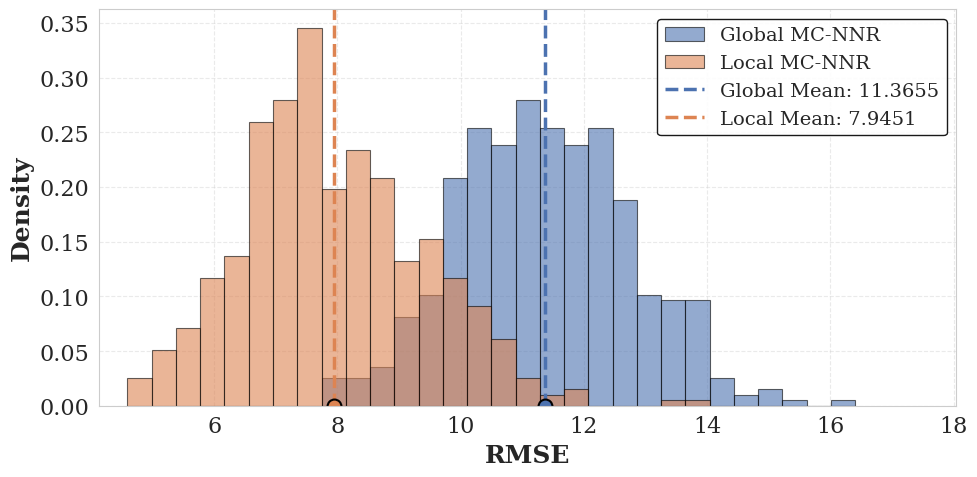

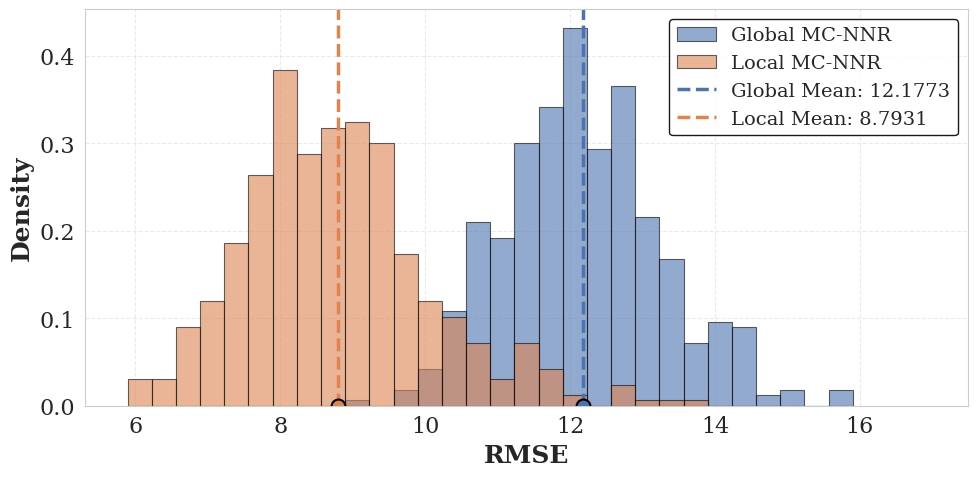

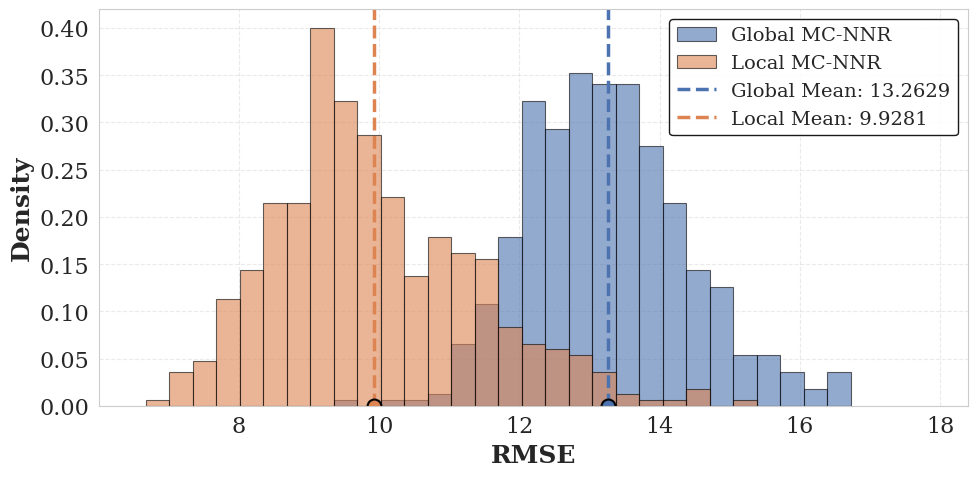

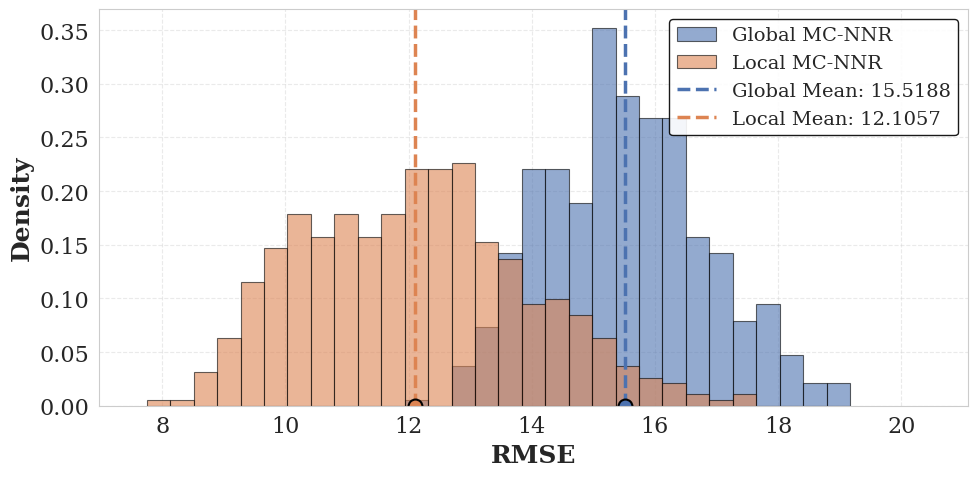

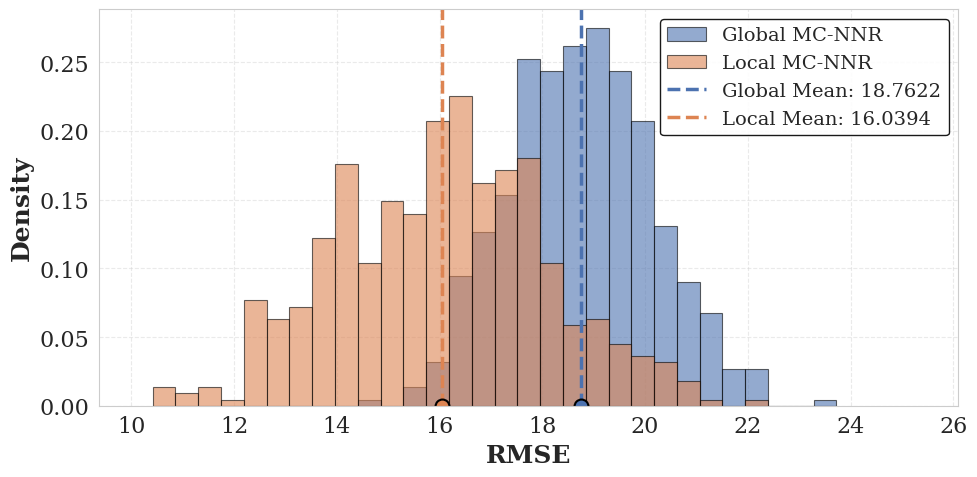

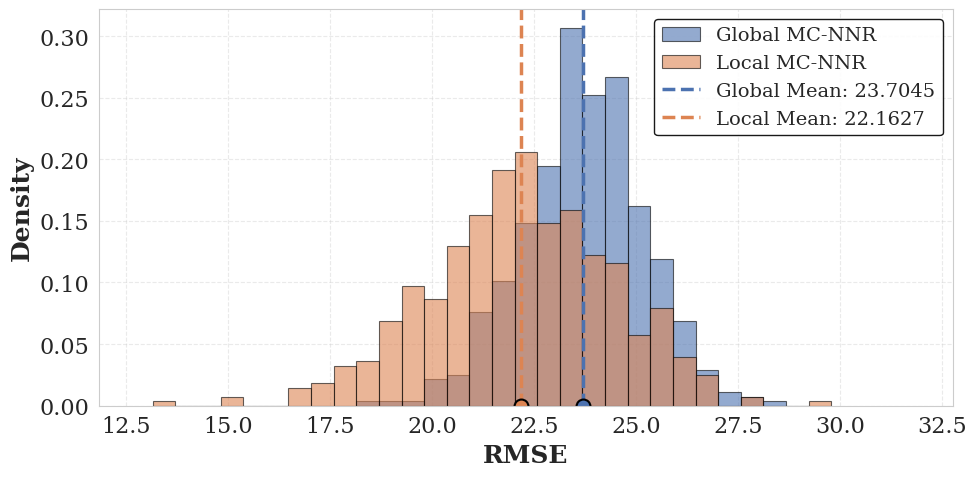

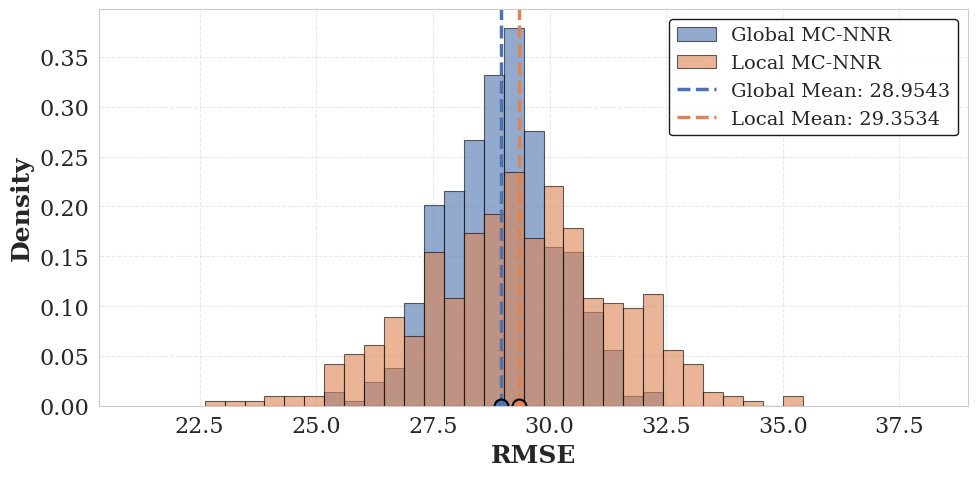

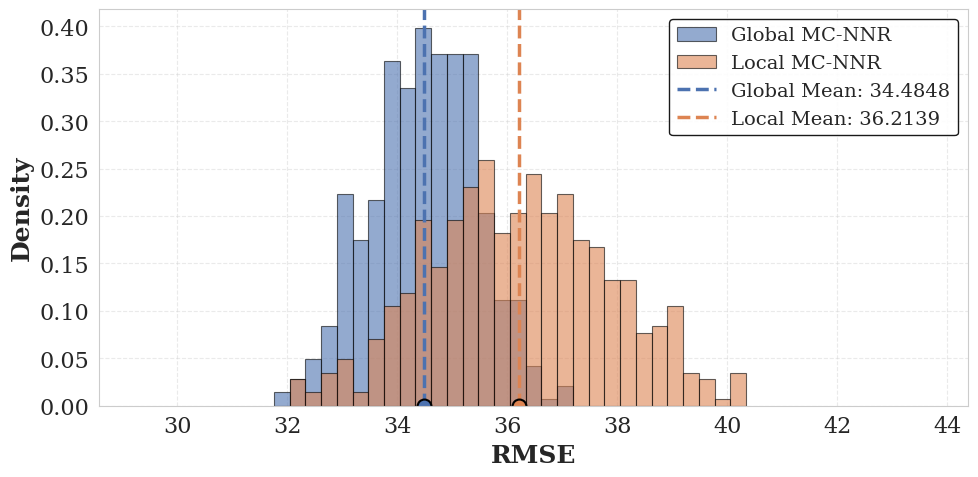

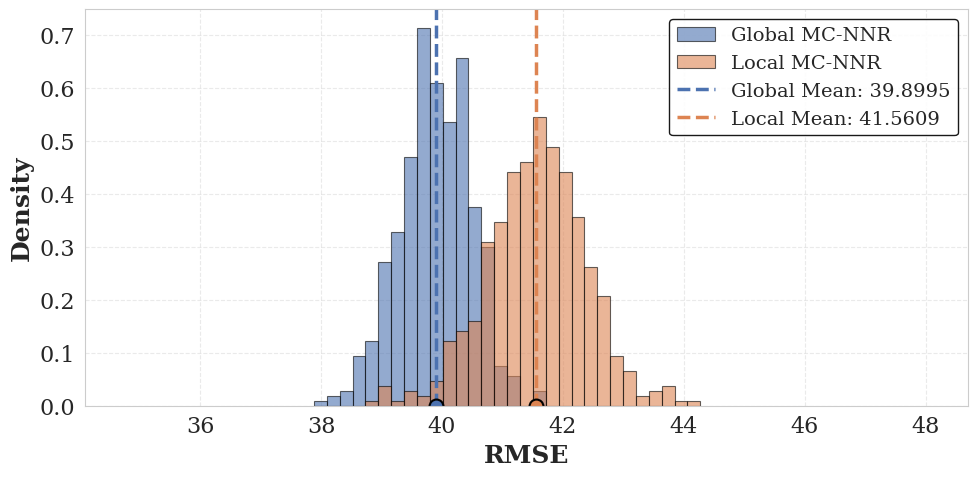

In [ ]:
import warnings
import os

M = 500

# Set seed for reproducibility
np.random.seed(2025)

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

percentages_to_hide = [0.1 * i for i in range(1, 10)]
soft_impute_rank_to_test = 3 # Example max_rank for SoftImpute

# Directory to save results (figures and RMSE lists)
results_dir = "results_random_missing_evaluation" # Changed directory name
os.makedirs(FIG_DIR_0125_MC + results_dir, exist_ok=True)

# --- Data Storage ---
# Dictionaries to store combined RMSEs for each percentage
all_global_rmses_by_percentage = {p: [] for p in percentages_to_hide}
all_local_rmses_by_percentage = {p: [] for p in percentages_to_hide}

# --- Global variables that 'rmse' and 'choose_subset_indices' might need ---
if 'X' not in globals() or X is None:
    print("INFO: Global data matrix 'X' is not defined. Using a random 100x6 matrix for demonstration.")
    X = np.random.rand(100, 6)

if 'M' not in globals() or M is None:
    print("INFO: Global number of iterations 'M' is not defined. Using M=10 for demonstration.")
    M = 10

# --- Iteration and Evaluation for 'random' scheme ---
for p_hide in percentages_to_hide:
    print(f"\nProcessing for 'random' scheme with overall percentage_to_hide: {p_hide*100:.0f}%")

    # Call the rmse function for 'random' scheme
    # The 'percentage_rows_missing_others' parameter is interpreted by 'rmse' function
    # as the overall percentage of entries to hide for the 'random' scheme.
    global_rmse_custom, local_rmse_custom = rmse(
        random_scheme='random',
        percentage_rows_missing_others=p_hide, # This is the overall percentage to hide
        soft_impute_max_rank=soft_impute_rank_to_test
        # No fixed_cols_observed needed for 'random' scheme
    )

    # Store the raw RMSE lists (can contain NaNs) for saving
    current_percentage_global_rmses_raw = global_rmse_custom
    current_percentage_local_rmses_raw = local_rmse_custom

    # For plotting in the summary boxplot, store NaN-filtered lists
    # global_rmse_custom and local_rmse_custom are lists of M RMSE values from the rmse() call
    all_global_rmses_by_percentage[p_hide] = [r for r in global_rmse_custom if not np.isnan(r)]
    all_local_rmses_by_percentage[p_hide] = [r for r in local_rmse_custom if not np.isnan(r)]

    print(f"  Results for 'random' scheme, p_hide {p_hide*100:.0f}%:")
    if global_rmse_custom: # Check if list is not empty/None
         print(f"    Global RMSEs (mean): {np.nanmean(global_rmse_custom):.4f} (first 3: {['{:.4f}'.format(r) if not np.isnan(r) else 'nan' for r in global_rmse_custom[:3]]})")
    if local_rmse_custom: # Check if list is not empty/None
         print(f"    Local RMSEs (mean): {np.nanmean(local_rmse_custom):.4f} (first 3: {['{:.4f}'.format(r) if not np.isnan(r) else 'nan' for r in local_rmse_custom[:3]]})")

    # Generate and save individual plot for this specific percentage
    fig_identifier = f'random_perc_{int(p_hide*100)}_rank{soft_impute_rank_to_test}'
    plot_file_name = os.path.join(results_dir, fig_identifier) # Full path for the plot
    plot_rmse(global_rmse_custom, local_rmse_custom, fig_text=plot_file_name, method = 'MC-NNR')

    # Save the raw RMSE lists for the current percentage to files
    global_rmse_filename = os.path.join(results_dir, f"global_rmses_random_perc_{int(p_hide*100)}_rank{soft_impute_rank_to_test}.txt")
    local_rmse_filename = os.path.join(results_dir, f"local_rmses_random_perc_{int(p_hide*100)}_rank{soft_impute_rank_to_test}.txt")

    try:
        np.savetxt(global_rmse_filename, current_percentage_global_rmses_raw, fmt='%.8f', header=f'Global RMSEs for random scheme, {p_hide*100}% hidden, rank {soft_impute_rank_to_test}')
        print(f"\n  Saved global RMSEs for p_hide={p_hide*100:.0f}% to {global_rmse_filename}")
    except Exception as e:
        print(f"  Error saving global RMSEs for p_hide={p_hide*100:.0f}%: {e}")

    try:
        np.savetxt(local_rmse_filename, current_percentage_local_rmses_raw, fmt='%.8f', header=f'Local RMSEs for random scheme, {p_hide*100}% hidden, rank {soft_impute_rank_to_test}')
        print(f"  Saved local RMSEs for p_hide={p_hide*100:.0f}% to {local_rmse_filename}")
    except Exception as e:
        print(f"  Error saving local RMSEs for p_hide={p_hide*100:.0f}%: {e}")

print("\n--- All percentages processed for 'random' scheme. ---")

In [ ]:
# --- Combined Final Summary Boxplot for 'random' scheme ---
labels = [f"{p*100:.0f}%" for p in percentages_to_hide]
x_ticks_positions = np.arange(len(labels)) # Use this for positioning groups
width = 0.35  # the width of the bars/boxes

# Filter labels to match available data
valid_labels_global = [f"{p*100:.0f}%" for p in percentages_to_hide if all_global_rmses_by_percentage[p]]
valid_labels_local = [f"{p*100:.0f}%" for p in percentages_to_hide if all_local_rmses_by_percentage[p]]

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for plotting, considering only percentages with actual data
plot_percentages = [p for p in percentages_to_hide if all_global_rmses_by_percentage.get(p) or all_local_rmses_by_percentage.get(p)]

if not plot_percentages:
    print("\nNo data available for combined summary boxplot (global and local RMSEs are missing for all percentages).")
else:
    labels_for_plot = [f"{p*100:.0f}%" for p in plot_percentages]
    x_ticks_positions_for_plot = np.arange(len(labels_for_plot))

    data_group1 = [all_global_rmses_by_percentage[p] for p in plot_percentages if all_global_rmses_by_percentage.get(p)] # Ensure list is not empty
    data_group2 = [all_local_rmses_by_percentage[p] for p in plot_percentages if all_local_rmses_by_percentage.get(p)] # Ensure list is not empty

    # Filter out groups where one of the datasets might be empty if they were not filtered before all_..._by_percentage
    # This step ensures data_group1 and data_group2 have corresponding entries for each label
    valid_indices = [i for i, p in enumerate(plot_percentages) if all_global_rmses_by_percentage.get(p) and all_local_rmses_by_percentage.get(p)]
    if not valid_indices:
         print("\nNo percentages found where both Global and Local RMSE data are available for the combined plot.")
    else:
        final_labels = [labels_for_plot[i] for i in valid_indices]
        final_x_ticks = x_ticks_positions_for_plot[valid_indices] # Use original x_ticks_positions for correct label mapping
        final_data_group1 = [data_group1[valid_labels_global.index(l)] for l in final_labels if l in [f"{p*100:.0f}%" for p in percentages_to_hide if all_global_rmses_by_percentage.get(p)]] # Re-map to original index
        final_data_group2 = [data_group2[valid_labels_local.index(l)] for l in final_labels if l in [f"{p*100:.0f}%" for p in percentages_to_hide if all_local_rmses_by_percentage.get(p)]]


        if not final_data_group1 or not final_data_group2 or len(final_data_group1) != len(final_data_group2):
            print("\nInsufficient corresponding data for Global and Local RMSEs to create a combined plot.")
        else:
            bp1 = ax.boxplot(final_data_group1, positions=final_x_ticks - width/2, widths=width*0.8, patch_artist=True,
                             boxprops=dict(facecolor='lightblue', edgecolor='blue'),
                             medianprops=dict(color='navy'), whiskerprops=dict(color='blue'),
                             capprops=dict(color='blue'), flierprops=dict(markerfacecolor='blue', markeredgecolor='blue', marker='o', markersize=5))

            bp2 = ax.boxplot(final_data_group2, positions=final_x_ticks + width/2, widths=width*0.8, patch_artist=True,
                             boxprops=dict(facecolor='lightgreen', edgecolor='green'),
                             medianprops=dict(color='darkgreen'), whiskerprops=dict(color='green'),
                             capprops=dict(color='green'), flierprops=dict(markerfacecolor='green', markeredgecolor='green', marker='o', markersize=5))

            ax.set_ylabel('RMSE', fontweight='bold', fontsize = 20)
            ax.set_xlabel('Overall Percentage of Hidden Entries', fontweight='bold', fontsize = 20) # Changed label
            ax.set_title(f'Comparison of Global and Local MC-NNR', fontweight='bold', fontsize = 20) # Changed title
            ax.set_xticks(final_x_ticks)
            ax.set_xticklabels(final_labels)
            ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Global RMSE', 'Local RMSE'], loc='upper right')
            ax.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()

            summary_combined_fig_path = os.path.join(FIG_DIR_0125_MC+results_dir, f"summary_boxplot_combined_rmse_random_scheme_rank{soft_impute_rank_to_test}.pdf") # Changed filename
            try:
                plt.savefig(summary_combined_fig_path)
                print(f"\nSaved combined summary RMSE boxplot to {summary_combined_fig_path}")
            except Exception as e:
                print(f"Error saving combined summary RMSE boxplot: {e}")
            plt.close()

print("\nScript finished.")


Saved combined summary RMSE boxplot to /content/drive/MyDrive/LLM causality/Figures/matrix_completion/results_random_missing_evaluation/summary_boxplot_combined_rmse_random_scheme_rank3.pdf

Script finished.
